In [55]:
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime
from neqsim.thermo import TPflash, fluid, fluidComposition, phaseenvelope
from neqsim.thermo.thermoTools import printFrame, printFluid, dataFrame, table, jNeqSim

In [56]:
# Start by creating a fluid in neqsim
fluid1 = fluid("srk")  # create a fluid using the SRK-EoS
fluid1.setTemperature(-50.15, "C")
fluid1.setPressure(40.0, "bara")
fluid1.addComponent("nitrogen", 1.0)
fluid1.addComponent("CO2", 3.3)
fluid1.addComponent("methane", 80.0)
fluid1.addComponent("ethane", 6.0)
fluid1.addComponent("propane", 3.0)
fluid1.addComponent("i-butane", 3.0)
fluid1.addComponent("n-butane", 2.0)
fluid1.addComponent("i-pentane", 1.4)
fluid1.addComponent("n-pentane", 0.2)
fluid1.addComponent("n-hexane", 0.1)
fluid1.setMixingRule("classic")  # classic will use binary kij

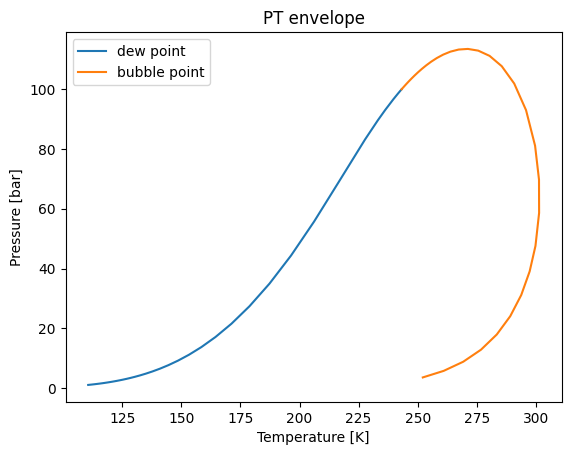

In [57]:
thermoOps = jNeqSim.thermodynamicOperations.ThermodynamicOperations(fluid1)
thermoOps.calcPTphaseEnvelope(True, 1.0)

plt.plot(
    list(thermoOps.getOperation().get("dewT")),
    list(thermoOps.getOperation().get("dewP")),
    label="dew point",
)
plt.plot(
    list(thermoOps.getOperation().get("bubT")),
    list(thermoOps.getOperation().get("bubP")),
    label="bubble point",
)
plt.title("PT envelope")
plt.xlabel("Temperature [K]")
plt.ylabel("Pressure [bar]")
plt.legend()
plt.show()

In [58]:
start = datetime.now()


TPflash(fluid1)
print(f"elapsed time: {datetime.now() - start}")

"""
Print results (number of phases at equilibrium and density).
For how to read more properties see: propertiesOfNaturalGas.py
"""
print("number of phases:", fluid1.getNumberOfPhases())
# printFluid(fluid1)
dataFrame(fluid1)

elapsed time: 0:00:00
number of phases: 1


,0,1,2,3,4,5,6
0,,total,GAS,,,,
1,nitrogen,1E-2,1E-2,,,,[mole fraction]
2,CO2,3.3E-2,3.3E-2,,,,[mole fraction]
3,methane,8E-1,8E-1,,,,[mole fraction]
4,ethane,6E-2,6E-2,,,,[mole fraction]
5,propane,3E-2,3E-2,,,,[mole fraction]
6,i-butane,3E-2,3E-2,,,,[mole fraction]
7,n-butane,2E-2,2E-2,,,,[mole fraction]
8,i-pentane,1.4E-2,1.4E-2,,,,[mole fraction]
9,n-pentane,2E-3,2E-3,,,,[mole fraction]


In [59]:
components = [c for c in fluid1.getComponentNames()]
phases = [p for p in fluid1.getPhases() if p]

In [60]:
outputs = {}

for phase in phases:
    for component in components:
        phase_name = phase.getPhaseTypeName()
        outputs[f"{phase_name}_{component}"] = phase.getComponent(component).getx()

pd.DataFrame.from_records([outputs]).round(2)

,gas_nitrogen,gas_CO2,gas_methane,gas_ethane,gas_propane,gas_i-butane,gas_n-butane,gas_i-pentane,gas_n-pentane,gas_n-hexane,liquid_nitrogen,liquid_CO2,liquid_methane,liquid_ethane,liquid_propane,liquid_i-butane,liquid_n-butane,liquid_i-pentane,liquid_n-pentane,liquid_n-hexane
0,0.01,0.03,0.8,0.06,0.03,0.03,0.02,0.01,0.0,0.0,0.01,0.03,0.8,0.06,0.03,0.03,0.02,0.01,0.0,0.0
